# What are convnets learning 

## Resources
- [Lecture 12 | Visualizing and Understanding](https://www.youtube.com/watch?v=6wcs6szJWMY)
- [C4W4L07 What are deep CNs learning](https://www.youtube.com/watch?v=ChoV5h7tw5A)
- https://towardsdatascience.com/visual-interpretability-for-convolutional-neural-networks-2453856210ce
- https://cs231n.github.io/understanding-cnn/
- http://yosinski.com/deepvis
- https://distill.pub/2017/feature-visualization/

## Reference Paper 
- [1] [Visualizing and Understanding Convolutional Networks,
Matthew D Zeiler, Rob Fergus](https://arxiv.org/abs/1311.2901)
- [2] [Adaptive Deconvolutional Networks for Mid and High Level Feature Learning, Matthew D. Zeiler, Graham W. Taylor and Rob Fergus](https://cs.nyu.edu/~fergus/drafts/deconv_iccv_names.pdf)

## Repos to reference for code
- https://github.com/TooTouch/WhiteBox-Part1
- https://github.com/huybery/VisualizingCNN
- https://github.com/utkuozbulak/pytorch-cnn-visualizations#gradient-visualization **[Main repo to reference, contains other visualizations also]**

In [2]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from collections import OrderedDict

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"
# available_device = "cpu"

print(f"{available_device} is available")
device = torch.device(device=available_device)
device

cuda is available


device(type='cuda')

## Let's Load a image
![](./husky_1.jpg)

(224, 224, 3)


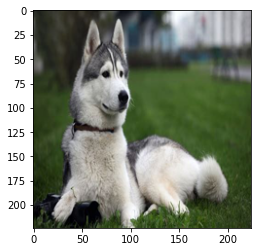

In [5]:
file_name = "husky_1.jpg" 
image = Image.open(file_name)
image_224 =  np.array(image.resize((224,224)))
print(image_224.shape)
plt.imshow(image_224)

In [6]:
transform = transforms.ToTensor()
image_tensor = transform(image_224)
image_in = image_tensor.unsqueeze(0)
image_in.shape

torch.Size([1, 3, 224, 224])

## Loading AlexNet pretrained Model for visualizations

In [7]:
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

![](./alexnet_arch.png)

## Looking into features part of the AlexNet

In [8]:
feature_layers = list(model.features)
feature_layers[-3:]

[Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [9]:
def get_layer_name(m, idx):
    layer_name = str(m).partition("(")[0]
    return layer_name + f" {idx}"

In [10]:
get_layer_name(feature_layers[10],10)

'Conv2d 10'

In [25]:
def forward_pass(x) :
    conv_layers_idx = [0, 3, 6, 8, 10]
    weight_list = []
    bias_list = []
    activation_list = OrderedDict()
    switches = OrderedDict()
    output_list = OrderedDict()
    layer_names = []
    
#     if grad=False:
#         with torch.no_grad():
#     else:
  
    for idx, m in enumerate(model.features): # model.features
        layer_name = get_layer_name(m,idx)
        print(layer_name)
#         print(m)

        if isinstance(m, nn.Conv2d):
            conv_weights = m.weight
            x = m(x)

#             print(f"conv_weights shape {conv_weights.shape}")
            weight_list.append(conv_weights)
            bias_list.append(m.bias)
            activation_list[idx] = x
            layer_names.append(layer_name)


        elif isinstance(m, nn.MaxPool2d):
            m.return_indices = True ## We want pool inidices/switches for deconvolution later
            x, switch = m(x)
            switches[idx] = switch
            layer_names.append(layer_name)
            m.return_indices = False ## Off for later

        else:            
            x = m(x)
        output_list[idx] = x   
        print(x.shape)
#         x = out_m
    #         break
    return weight_list, bias_list, activation_list, switches, output_list,layer_names,


In [26]:
weight_list, bias_list, activation_list, switches, output_list,layer_names = forward_pass(image_in)

Conv2d 0
torch.Size([1, 64, 55, 55])
ReLU 1
torch.Size([1, 64, 55, 55])
MaxPool2d 2
torch.Size([1, 64, 27, 27])
Conv2d 3
torch.Size([1, 192, 27, 27])
ReLU 4
torch.Size([1, 192, 27, 27])
MaxPool2d 5
torch.Size([1, 192, 13, 13])
Conv2d 6
torch.Size([1, 384, 13, 13])
ReLU 7
torch.Size([1, 384, 13, 13])
Conv2d 8
torch.Size([1, 256, 13, 13])
ReLU 9
torch.Size([1, 256, 13, 13])
Conv2d 10
torch.Size([1, 256, 13, 13])
ReLU 11
torch.Size([1, 256, 13, 13])
MaxPool2d 12
torch.Size([1, 256, 6, 6])


In [15]:
len(output_list)

13

In [16]:
output_list[12].shape

torch.Size([1, 256, 6, 6])

In [17]:
256 *6 *6

9216

In [18]:
len(weight_list) # 5 weight list for 5 conv layers

5

In [15]:
len(switches)

3

In [19]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

## To show the activation based on the given tensor grid.
def show_grid_tensor(grid_im, layer_name, n, c=None):
    fig = plt.figure(figsize=(15,15))
    print(layer_name)
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        plt.axis("off")
        ax.set_title(f"activation {i}")
    return plt

## Lets see the first 16 feature/activation map obtained from the 1st Conv layer when we send the husky image as an input
- i.e Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [27]:
al_1 = activation_list[0]
# al_1 = output_list[1]
grids_1 = torchvision.utils.make_grid(al_1)
grids_1.shape

torch.Size([64, 55, 55])

In [28]:
al_1.shape

torch.Size([1, 64, 55, 55])

Conv2d 0


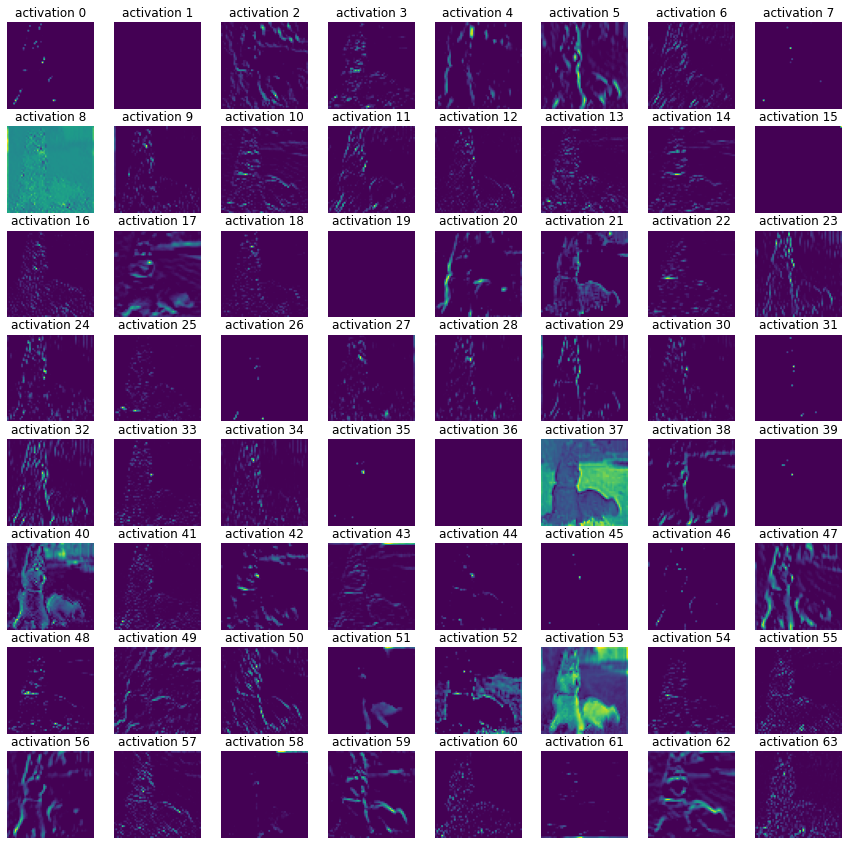

In [29]:
grid_plt = show_grid_tensor(grids_1, layer_names[0], 64)

## Activation by layer 3

In [124]:
al_3 = activation_list[6]
grids_3 = torchvision.utils.make_grid(al_3)
grids_3.shape

torch.Size([384, 13, 13])

Conv2d 10


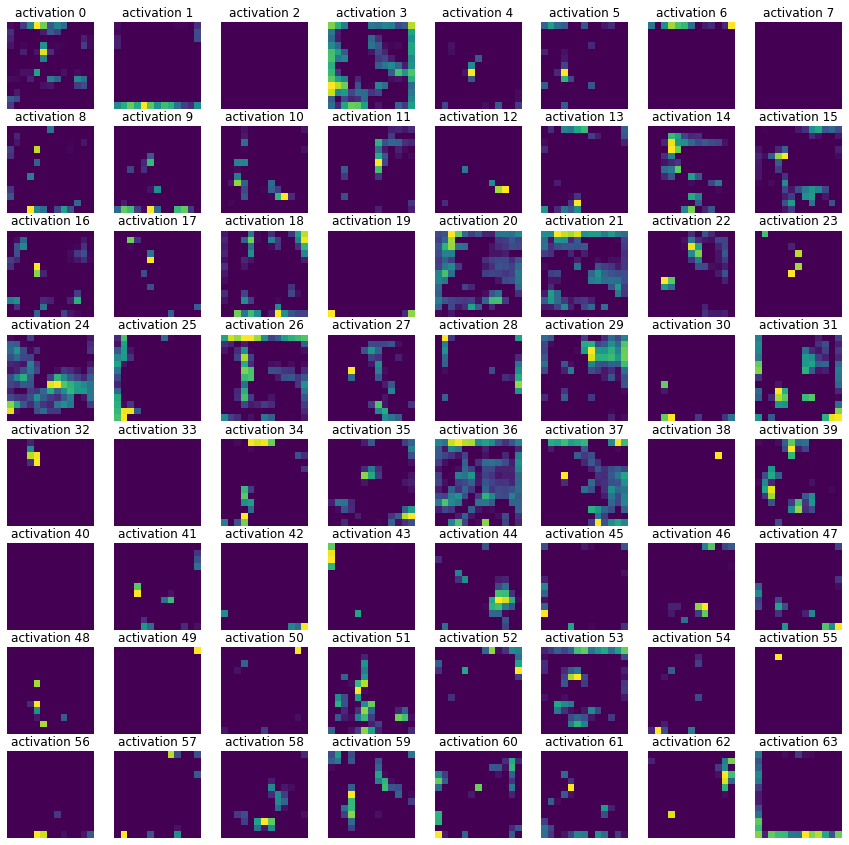

In [125]:
grid_plt = show_grid_tensor(grids_3, layer_names[6], 64)

## Lets See the weights/filters of the conv layer

In [20]:
weight_list[0].shape

torch.Size([64, 3, 11, 11])

In [21]:
filter0 = weight_list[0][0].unsqueeze(0)
filter0.shape

torch.Size([1, 3, 11, 11])

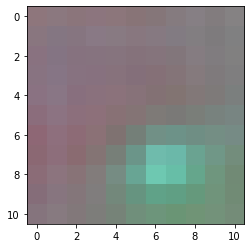

In [22]:
imshow(filter0.squeeze().permute(1, 2, 0))

## Looking at the output given by this filter 0

In [23]:
image_in.shape

torch.Size([1, 3, 224, 224])

## Passing the image to the 0th filter, 
- `out` is the Oth filter activation
- we then show this activation 

In [24]:
out = F.relu(F.conv2d(image_in, filter0, padding=2, stride=4))
out.shape

torch.Size([1, 1, 55, 55])

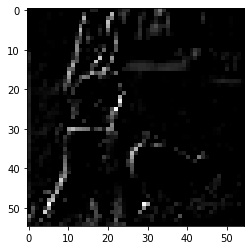

In [25]:
plt.imshow(out.squeeze(), cmap="gray")

In [32]:
(out - grids_1[0]).mean()

tensor(0.0654)

In [26]:
grids_1[0].shape

torch.Size([55, 55])

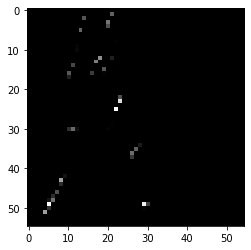

In [27]:
plt.imshow(grids_1[0], cmap="gray")

## Plotting Filter

In [15]:
def plot_filter(filters, layer_name,n):
    fig = plt.figure(figsize=(14,14))
    print(layer_name)
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        img = filters[i].squeeze().permute(1, 2, 0) / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(npimg)
        plt.axis("off")
        ax.set_title(f"filter {i}")
    return plt

## Looking at the 16 filters of shape 11 * 11 * 3 of 
### Layer 1

Conv2d 0


<module 'matplotlib.pyplot' from '/home/felladog/anaconda3/envs/deep/lib/python3.8/site-packages/matplotlib/pyplot.py'>

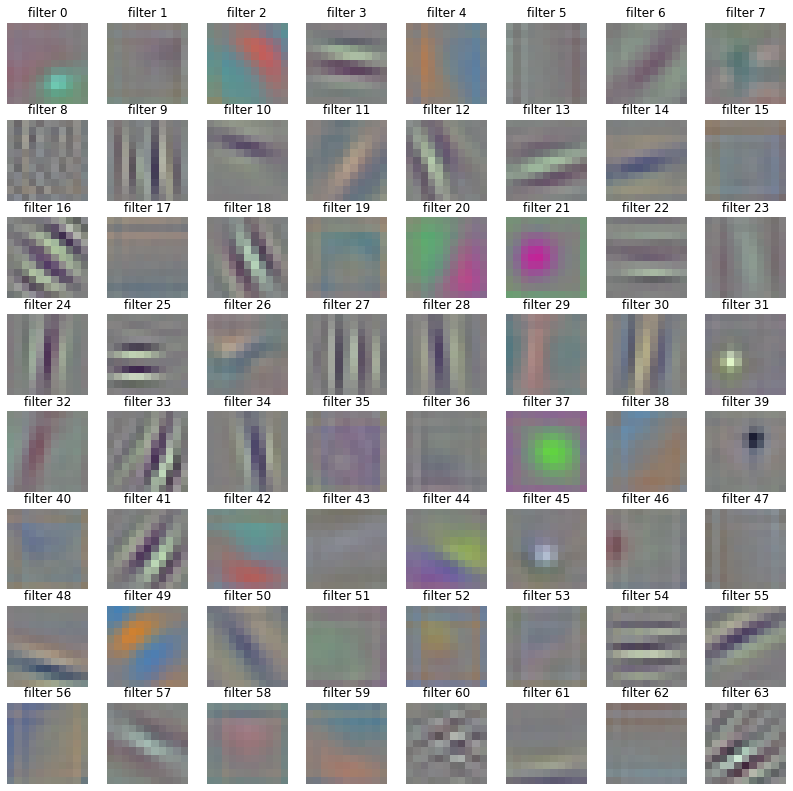

In [217]:
plot_filter(weight_list[0], layer_names[0], 64)

### Layer 2

In [37]:
weight_list[1].shape

torch.Size([192, 64, 5, 5])

# Visualizing using deconvnets

## Unpooling from the first maxpooling of the layer
- https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html#torch.nn.MaxUnpool2d
- ***Unpooling*** *: In the convnet, the max pooling operation is non-invertible, however we can obtain an 
approximate inverse by recording the locations of the maxima within each pooling region in a set of switch variables. In the deconvnet, the unpooling operation uses these switches to place the reconstructions from the layer above into appropriate locations, preserving the structure of the stimulus.* $_{[1]}$

In [715]:
conv_in = output_list[2]
conv_in.shape

torch.Size([1, 64, 27, 27])

In [716]:
switches.keys()

odict_keys([2, 5, 12])

In [717]:
d_un_pool = F.relu(F.max_unpool2d(conv_in, switches[2],3,2))
d_un_pool.shape

torch.Size([1, 64, 55, 55])

#### Plotting the activation obatined from unpooling of the 1st maxpooling activation.

obatined from max unpool 0


<module 'matplotlib.pyplot' from '/home/felladog/anaconda3/envs/deep/lib/python3.8/site-packages/matplotlib/pyplot.py'>

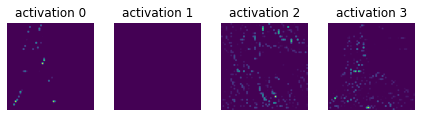

In [718]:
show_grid_tensor(torchvision.utils.make_grid(d_un_pool),"obatined from max unpool 0", 4)

#### Let's see the activation obatined before that same maxpooling

In [719]:
before_pooling = torchvision.utils.make_grid(output_list[1])

MaxPool2d 2


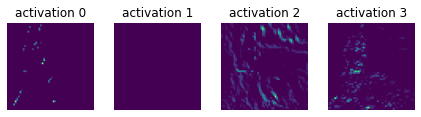

In [720]:
grid_plt = show_grid_tensor(before_pooling, layer_names[1], 4)

- same activations where found

## Convolution Transpose the output from layer 1

- https://pytorch.org/docs/stable/nn.functional.html#conv-transpose2d
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d

- ***Filtering*** *: The convnet uses learned filters to convolve the feature maps from the previous layer. To
Visualizing and Understandinginvert this, the deconvnet uses transposed versions of
the same filters, but applied to the rectified maps, not
the output of the layer beneath. In practice this means
flipping each filter vertically and horizontally.* $_{[1]}$



In [721]:
image_in.shape

torch.Size([1, 3, 224, 224])

In [722]:
weight_list[0].shape

torch.Size([64, 3, 11, 11])

In [723]:
len(bias_list)

5

In [724]:
bias_list[0].shape

torch.Size([64])

In [725]:
d_conv = F.conv_transpose2d(d_un_pool, weight_list[0], padding=2, stride=4,output_padding=1)
# d_conv = F.relu(d_conv)
d_conv.shape

torch.Size([1, 3, 224, 224])

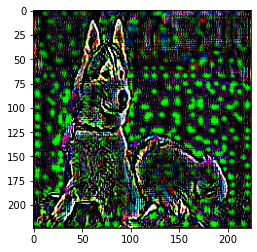

In [726]:
plt.imshow(d_conv.squeeze().permute(1,2,0).clamp(max=1,min=0))

In [727]:
(d_conv - image_in).mean()

tensor(-0.3831)

## Deconvolution
- Generating the input image from the output activation 

#### Merging the Max Unpooling and Conv transpose we can form Deconvolution architecture

![](./deconvnet.png)

Figure 1. Top: A deconvnet layer (left) attached to a con-
vnet layer (right). The deconvnet will reconstruct an ap-
proximate version of the convnet features from the layer
beneath. Bottom: An illustration of the unpooling oper-
ation in the deconvnet, using switches which record the
location of the local max in each pooling region (colored
zones) during pooling in the convnet.
$_{[1]}$

In [728]:
# Simple deconv arch for initial layer of alexnet
def simple_deconv_alex1(out_CRM, conv_weight, switch):
    '''
        out_CRM is the output obtained from passing the image through 
        1st conv --> relu ---> 1st maxpooling.
        switch is the pool indices obatained from the maxpooling
    '''
    unpooled_x = F.relu(F.max_unpool2d(out_CRM, switch,3,2))
    deconv_x = F.conv_transpose2d(unpooled_x, conv_weight, padding=2, stride=4, output_padding=1)
    return deconv_x

In [729]:
"""
    0 is for 1st conv,
    2 is for the max pool layer number,
"""
deconv_image = simple_deconv_alex1(output_list[2], 
                                    weight_list[0],
                                    switches[2])
deconv_image.shape

torch.Size([1, 3, 224, 224])

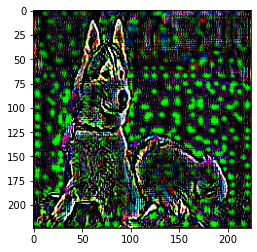

In [730]:
plt.imshow(deconv_image.squeeze().permute(1,2,0).clamp(max=1,min=0))

In [731]:
(d_conv == deconv_image).all()

tensor(True)

#### Checking the husky prediction index

In [732]:
model.eval()
output = model(image_in) #.to(device))

In [733]:
output.argmax()

tensor(578)

#### Does the deconvoluted image generates the same output

In [734]:
model.eval()
out = model(deconv_image) #.to(device))

In [735]:
out.argmax()

tensor(815)

## Creating the Deconvolution Architecture for Alexnet

- [ Question about 'conv2deconv_indices' #2 ](https://github.com/huybery/VisualizingCNN/issues/2)
- self.conv2deconv_indices and self.unpool2pool_indices are defined so that the weight can be assigned to the respective layers
- The layers in deconv architecture is opposite to the layers in conv architecture

In [99]:
len(feature_layers)

13

In [100]:
feature_layers

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [664]:
class DeConvAlexNet(nn.Module):
    def __init__(self):
        super(DeConvAlexNet, self).__init__()
        
        ## deconv 1 - reverse of last feature layers in alexnet architecture 
        self.unpool1 = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0)
#         self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, 
                                          kernel_size=3, stride=1, padding=1)
        
        ## deconv 2 - reverse of middle feature layers in alexnet architecture
        self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=384, 
                                          kernel_size=3, stride=1, padding=1)
        
        ## deconv 3 - reverse of middle feature layers in alexnet architecture 
        self.deconv3 = nn.ConvTranspose2d(in_channels=384, out_channels=192,
                                          kernel_size=3, stride=1, padding=1)
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0)
        self.deconv4 = nn.ConvTranspose2d(in_channels=192, out_channels=64,
                                          kernel_size=5, stride=1, padding=2)
        
        ## 
        self.unpool3 = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0)
        self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3,
                                          kernel_size=11, stride=4,  padding=2, output_padding=1)

        ## conv_layers_idx = [1, 2, 3, 5, 7]
        self.conv_weight_indices_reverse = {
            0:7, 3:5, 6:3, 8:2, 10:1,
            12:0, 5:4, 2:6
        } 
        # conv weight of 0 is equal to the weight of 7th deconv `deconv5`
        self.unpool_locs_indices_reverse = {
            0:12, 4:5, 6:2
        }
        self.layer_outs = OrderedDict()
        self.init_weights()
        
    def init_weights(self):
        alexnet_conv = torchvision.models.alexnet(pretrained=True)
        deconv_modules = list(self.modules())[1:]
        for f_idx, features in enumerate(list(alexnet_conv.features)):
            if isinstance(features, nn.Conv2d):
#                 print(f" {f_idx} --> {self.conv_weight_indices_reverse[f_idx]}")
                m = deconv_modules[self.conv_weight_indices_reverse[f_idx]]
                m.weight.data = features.weight.data
#                 m.bias.data = features.bias.data

    def features(self):
        return list(self.modules())[1:]
    
    def reset_out(self):
        self.layer_outs = OrderedDict()
        
    def forward(self, x, layer, switches):
        '''
            x is the output obtained from passing the image through 
            conv --> relu --->  maxpooling.
            switch is the pool indices obatained from the maxpooling
        '''
        features = self.features()
        if layer in self.conv_weight_indices_reverse:
            start_deconv_at = self.conv_weight_indices_reverse[layer]
        else:
            raise ValueError("Layer index not in the feature map")
            
        for s in range(start_deconv_at, len(features)):
            if isinstance(features[s], nn.MaxUnpool2d):
#                 print("need pool locs")
                x = F.relu(features[s](x, switches[self.unpool_locs_indices_reverse[s]]))
#             elif s==(len(features)-1):
#                 x = features[s](x)
#                 print("at last")
                # no need to rectify the last layer.
            else: 
#                 print("new layer")
#                 print(x.shape)
                x = features[s](x)
    
            self.layer_outs[s] = x
        ## need to define switches,
        return x

In [665]:
deconv = DeConvAlexNet()
print(deconv)

DeConvAlexNet(
  (unpool1): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (unpool2): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv4): ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (unpool3): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), output_padding=(1, 1))
)


### Checking if the weights are transferred correctly or not

In [666]:
print(deconv.features()[1])
deconv.features()[1].weight.data.shape

ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([256, 256, 3, 3])

In [20]:
print(feature_layers[10])
feature_layers[10].weight.data.shape

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([256, 256, 3, 3])

In [667]:
(feature_layers[10].weight.data == deconv.features()[1].weight.data).all()

tensor(True)

### Trying a forward pass in deconv net

#### Lets get pool locs or switches for the forward passs

In [668]:
"""
    0 is for 1st conv,
    2 is for the max pool layer number,
"""
# deconv_image = simple_deconv_alex1(output_list[2], 
#                                    weight_list[0],
#                                    switches[2])
# deconv_image.shape

layer_idx = 2
with torch.no_grad():
    image_out = deconv(output_list[layer_idx],layer_idx,switches)
image_out.shape

torch.Size([1, 3, 224, 224])

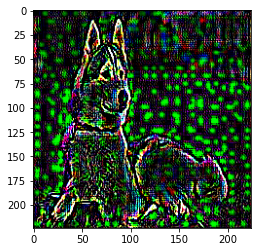

In [669]:
plt.imshow(image_out.squeeze().permute(1,2,0).clamp(max=1,min=0))

In [603]:
# toPil = transforms.ToPILImage(mode='RGB')
# with torch.no_grad():
#     pil_random_image = toPil(image_out[0])
# plt.imshow(pil_random_image)
# plt.show()

In [24]:
deconv.layer_outs.keys()

odict_keys([6, 7])

MaxPool2d 2


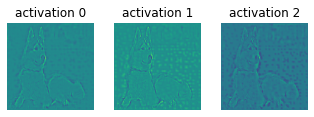

In [25]:
before_conv = torchvision.utils.make_grid(deconv.layer_outs[7]) #.shape
grid_plt = show_grid_tensor(before_conv, layer_names[1], 3)

### From the n layer of the features

torch.Size([1, 3, 224, 224])


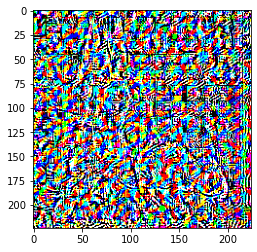

In [670]:
# {
#   0:7, 3:5, 6:3, 8:2, 10:1,
#   12:0, 5:4, 2:6
# } 
layer_idx = 12
with torch.no_grad():
    deconv.reset_out()
    image_out_l = deconv(output_list[layer_idx],layer_idx,switches)
print(image_out_l.shape)
plt.imshow(image_out_l.squeeze().permute(1,2,0).clamp(max=1,min=0))#, cmap="gray")

In [27]:
deconv.layer_outs.keys()

odict_keys([0, 1, 2, 3, 4, 5, 6, 7])

8


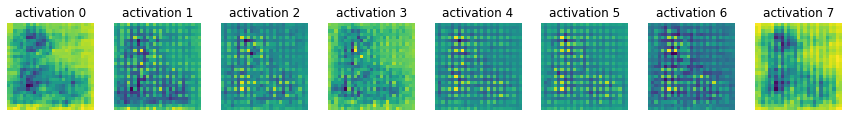

In [29]:
before_conv = torchvision.utils.make_grid(deconv.layer_outs[5]) #.shape
grid_plt = show_grid_tensor(before_conv, "8", 8)

## Trying to implement from http://yosinski.com/deepvis

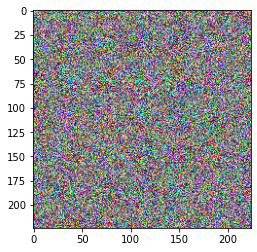

In [205]:
random_image = torch.rand(1,3,224,224)
plt.imshow(random_image.squeeze().permute(1,2,0))

In [62]:
r_weight_list, _ , r_activation_list, r_switches, r_output_list, r_layer_names = forward_pass(random_image)

Conv2d 0
ReLU 1
MaxPool2d 2
Conv2d 3
ReLU 4
MaxPool2d 5
Conv2d 6
ReLU 7
Conv2d 8
ReLU 9
Conv2d 10
ReLU 11
MaxPool2d 12


In [116]:
random_al_1 = r_activation_list[0]
# random_al_1 = r_output_list[1]
random_grids_1 = torchvision.utils.make_grid(random_al_1)
random_grids_1.shape

torch.Size([64, 55, 55])

conv 1


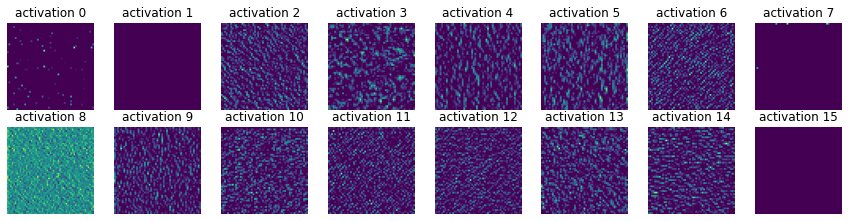

In [130]:
grid_plt = show_grid_tensor(random_grids_1, "conv 1", 16)

In [111]:
# layer_idx = 0
# with torch.no_grad():
#     random_image_out = deconv(r_output_list[layer_idx],layer_idx,r_switches)
# print(random_image_out.shape)
# plt.imshow(random_image_out.squeeze().permute(1,2,0).clamp(max=1,min=0))#, cmap="gray")

In [37]:
activation = random_image

for i in range(upto_feature_idx):
    activation = model.features[i](activation)
    print(activation.shape)

torch.Size([1, 64, 55, 55])
torch.Size([1, 64, 55, 55])
torch.Size([1, 64, 27, 27])
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 13, 13])
torch.Size([1, 384, 13, 13])
torch.Size([1, 384, 13, 13])
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])


In [41]:
def compute_loss(image,model, upto_feature_idx, filter_idx):
    
    activation = image
    for i in range(upto_feature_idx):
        activation = feature_layers[i](activation)
    
    activation_f = activation[0,filter_idx]
#     activation_f = activation

    loss = -torch.mean(activation_f) #.mean()

    return activation[0, filter_idx], loss

In [42]:
def generate_activation(image, upto_feature_idx, filter_idx, iteration=30) :

    image.requires_grad = True
    ### conv_layers_idx = [0, 3, 6, 8, 10]
    optimizer = optim.Adam([image], lr=0.1, weight_decay=1e-6)

    for i in range(iteration):

        optimizer.zero_grad()
        ac, loss = compute_loss(image, model,upto_feature_idx , filter_idx)

        # random_al_1 = ac[0]
        # al_1 = output_list[1]

    #     with torch.no_grad():
    #         plt.imshow(ac)

    #     print(loss.item())
        if i%5==0:
            print(loss.item())

        loss.backward()


        ## Gradient Ascent
        optimizer.step()
    #     with torch.no_grad():
    #         random_image += 0.2 * random_image.grad
    #         random_image.grad = None

    image.requires_grad = False
    return image

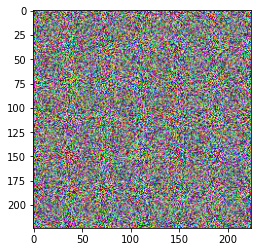

-0.004075828939676285
-10.953926086425781
-57.16563415527344
-117.25624084472656
-186.1833038330078
-260.72454833984375


In [45]:
random_image = torch.rand(1, 3, 224, 224)
filter_idx = 15
upto_feature_idx = 12
iteration = 30
plt.imshow(random_image.squeeze().permute(1,2,0).clamp(max=1, min=0))
plt.show()

random_image = generate_activation(random_image, upto_feature_idx, filter_idx, iteration=30)

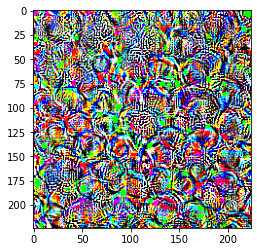

In [46]:
with torch.no_grad():
    plt.imshow(random_image.squeeze().permute(1,2,0).clamp(max=1, min=0))

In [34]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    
    recreated_im = im_as_var.data.clone().numpy()[0]
     # done because we we don't want the gradient to be calculated


    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)
#     print(recreated_im.shape)
    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

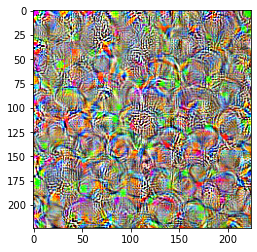

In [47]:
im = recreate_image(random_image)
plt.imshow(im)
plt.show()

## DeepDream
### Husky on Psychedelic [Just deep dreaming]


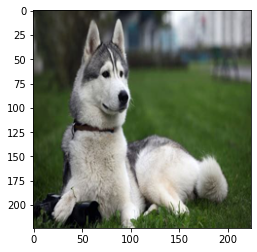

In [48]:
plt.imshow(image_in.squeeze().permute(1,2,0).clamp(max=1, min=0))

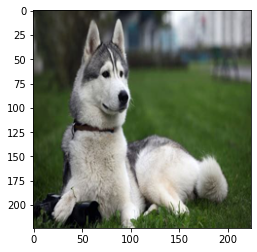

-0.09702391177415848
-14.649650573730469
-40.14988708496094
-68.96076202392578
-100.23983764648438
-133.08267211914062


In [49]:
filter_idx = 15
upto_feature_idx = 10
iteration = 30
husky_clone = image_in.clone()
plt.imshow(husky_clone.squeeze().permute(1,2,0).clamp(max=1, min=0))
plt.show()

husky_clone = generate_activation(husky_clone, upto_feature_idx, filter_idx, iteration=30)

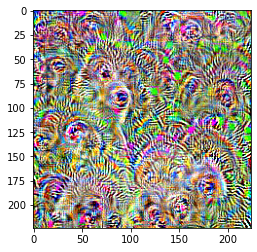

In [50]:
husky_out = recreate_image(husky_clone)
plt.imshow(husky_out)
plt.show()

In [51]:
model.eval()
out = model(husky_clone) #.to(device))
out.argmax()

tensor(380)

## Log for later
- [x] check the output of the layer before the final output from the deconv model
- [x] Filter maxmization to see what activates the filter
- [ ] show multiple such filter maxmization
- [ ] look into occlusion analysis
- [ ] Sailency maps 